In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from gfn.envs.hypergrid import HyperGrid
from gfn.envs.utils import get_flat_grid, build_grid
from gfn.envs.env import Env, AbstractStatesBatch
from gfn.samplers.actions_samplers import (UniformActionSampler, UniformBackwardsActionSampler,
                                          ModuleActionSampler, BackwardsModuleActionSampler)
import matplotlib.pyplot as plt
from gfn.samplers.trajectories_sampler import TrajectoriesSampler
from gfn.envs.hypergrid import HyperGrid
from gfn.preprocessors import IdentityPreprocessor, OneHotPreprocessor, KHotPreprocessor
import torch
import numpy as np
from gfn.models import NeuralNet, Uniform
from torch.nn.functional import one_hot
from gfn.losses import TrajectoryBalance

In [73]:
height = 64
ndim = 2
n_envs = 256
env = HyperGrid(ndim=ndim, height=height, n_envs=n_envs)

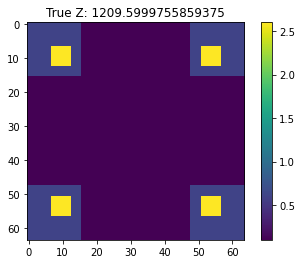

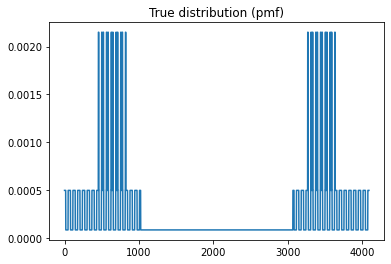

In [74]:
grid = build_grid(env)
flat_grid = get_flat_grid(env)

all_rewards = env.reward(grid)
true_Z = all_rewards.sum()
if ndim == 2:
    plt.imshow(all_rewards)
    plt.title('True Z: {}'.format(true_Z.item()))
    plt.colorbar()
    plt.show()

true_dist = env.reward(flat_grid)
true_dist /= true_dist.sum()

# print('True distribution: {}'.format(true_dist))
plt.plot(true_dist)
plt.title('True distribution (pmf)')
plt.show()

In [75]:
print(true_dist.numpy())

[0.00049603 0.00049603 0.00049603 ... 0.00049603 0.00049603 0.00049603]


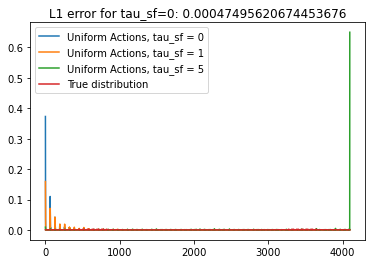

In [76]:
def validate(actions_sampler, n_envs=1000):
    validation_env = HyperGrid(ndim=ndim, height=height, n_envs=n_envs)
    validation_trajectories_sampler = TrajectoriesSampler(validation_env, actions_sampler)
    validation_trajectories = validation_trajectories_sampler.sample_trajectories()
    last_states = validation_trajectories.get_last_states_raw()
    last_states_idx = env.get_states_indices(env.StatesBatch(states=last_states))
    empirical_dist = torch.zeros_like(true_dist)
    for i in range(len(last_states_idx)):
        empirical_dist[last_states_idx[i]] += 1.

    empirical_dist /= empirical_dist.sum()
    l1_error = (empirical_dist - true_dist).abs().mean()

    return empirical_dist, l1_error

actions_sampler = UniformActionSampler()
empirical_dist, l1_error = validate(actions_sampler)

actions_sampler_1 = UniformActionSampler(sf_temperature = 1.)
empirical_dist_1, l1_error_1 = validate(actions_sampler_1)

actions_sampler_5 = UniformActionSampler(sf_temperature = 5.)
empirical_dist_5, l1_error_5 = validate(actions_sampler_5)

plt.plot(empirical_dist, label='Uniform Actions, tau_sf = 0')
plt.plot(empirical_dist_1, label='Uniform Actions, tau_sf = 1')
plt.plot(empirical_dist_5, label='Uniform Actions, tau_sf = 5')
plt.plot(true_dist, label='True distribution')
plt.title('L1 error for tau_sf=0: {}'.format(l1_error.item()))
plt.legend()
plt.show()

New LR: 0.001
TrueLogZ:  7.0980448722839355 , logZ:  0.09999999403953552 , l1:  0.0004707267216872424


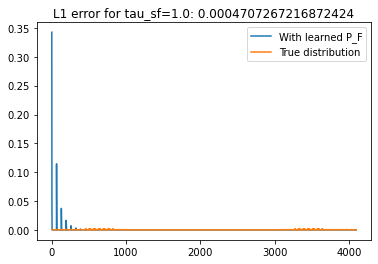

New LR: 0.001
TrueLogZ:  7.0980448722839355 , logZ:  5.041106224060059 , l1:  0.0003430904762353748


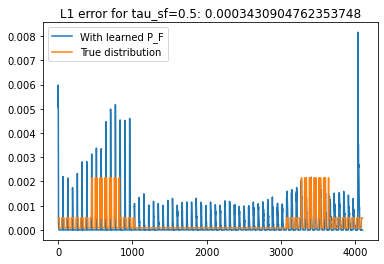

New LR: 0.0005
TrueLogZ:  7.0980448722839355 , logZ:  6.641481399536133 , l1:  0.00016133784083649516


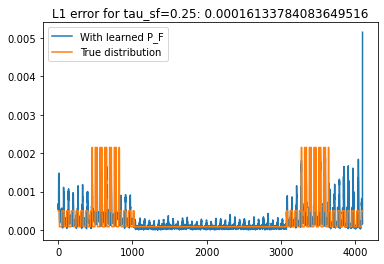

New LR: 0.0005
TrueLogZ:  7.0980448722839355 , logZ:  6.978268623352051 , l1:  0.000102830003015697


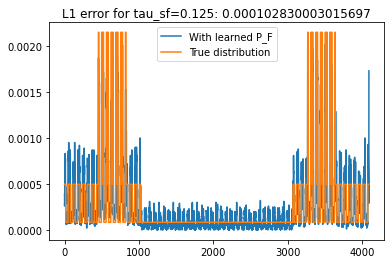

New LR: 0.0005
TrueLogZ:  7.0980448722839355 , logZ:  7.007659435272217 , l1:  8.504002471454442e-05


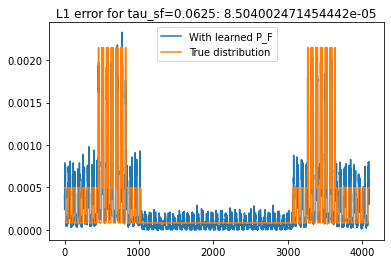

New LR: 0.00025
TrueLogZ:  7.0980448722839355 , logZ:  7.031562328338623 , l1:  6.943973858142272e-05


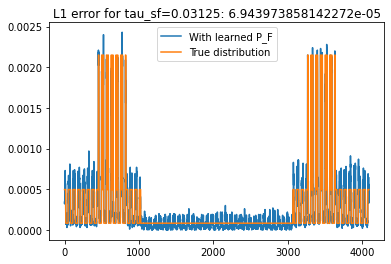

New LR: 0.00025
TrueLogZ:  7.0980448722839355 , logZ:  7.045294761657715 , l1:  6.226218829397112e-05


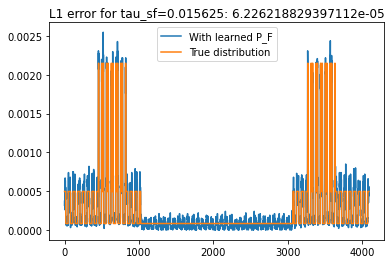

New LR: 0.00025
TrueLogZ:  7.0980448722839355 , logZ:  7.05237340927124 , l1:  5.7153054513037205e-05


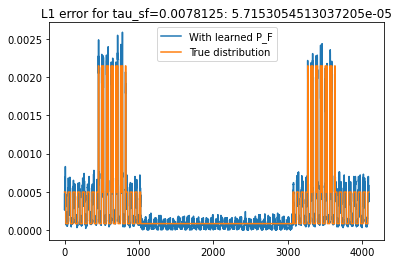

New LR: 0.00025
TrueLogZ:  7.0980448722839355 , logZ:  7.060980796813965 , l1:  5.271114787319675e-05


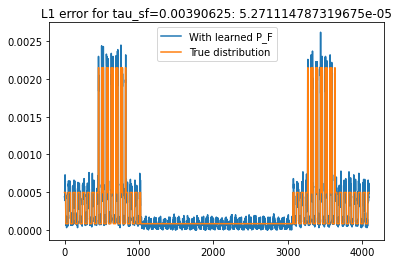

New LR: 0.00025
TrueLogZ:  7.0980448722839355 , logZ:  7.066618919372559 , l1:  5.007219442632049e-05


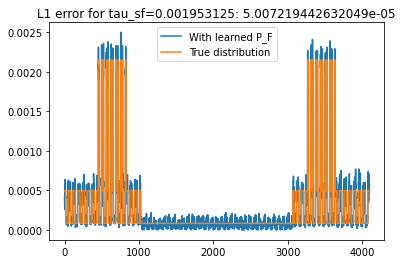

New LR: 0.000125
TrueLogZ:  7.0980448722839355 , logZ:  7.071651935577393 , l1:  4.817400986212306e-05


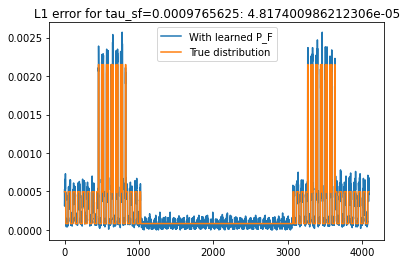

KeyboardInterrupt: 

In [77]:
preprocessor = KHotPreprocessor(env=env)
pf = NeuralNet(input_dim=preprocessor.output_dim, output_dim=env.n_actions, hidden_dim=256)
tie_parameters = True
pb = NeuralNet(input_dim=preprocessor.output_dim,
                output_dim=env.n_actions - 1,
                hidden_dim=256,
                torso=pf.torso if tie_parameters else None)
actions_sampler = ModuleActionSampler(preprocessor=preprocessor, module=pf, sf_temperature=1.)
trajectories_sampler = TrajectoriesSampler(env, actions_sampler)

LR = 1e-3
LR_Z = 0.1
temperature = 1.

optimizer = torch.optim.Adam([{'params': pf.parameters(), 'lr': LR}])
if tie_parameters:
    optimizer.add_param_group({'params': pb.last_layer.parameters(), 'lr': LR})
else:
    optimizer.add_param_group({'params': pb.parameters(), 'lr': LR})
logZ = torch.tensor(0.)
logZ.requires_grad_(True)
optimizer.add_param_group({'params': [logZ], 'lr': LR_Z})

loss_class = TrajectoryBalance(preprocessor=preprocessor, pf=pf, pb=pb, logZ=logZ)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 500, 1000, 2000, 5000], gamma=0.5)


losses = []
l1_distances = []
n_iters = 10000
for i in range(n_iters):
    trajectories = trajectories_sampler.sample_trajectories()
    loss = loss_class(trajectories)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    losses.append(loss.item())
    if i % 100 == 0:
        actions_sampler_sf_temperature = actions_sampler.sf_temperature
        actions_sampler.sf_temperature = 0.
        empirical_dist, l1 = validate(actions_sampler, n_envs=100000)
        print('New LR: {}'.format(optimizer.param_groups[0]['lr']))
        l1_distances.append(l1.item())
        print('TrueLogZ: ', torch.log(true_Z).item(),
         ', logZ: ', logZ.item(),
          ', l1: ', l1.item())

        l1_distances.append(l1.item())
        plt.plot(empirical_dist, label='With learned P_F')
        plt.plot(true_dist, label='True distribution')
        plt.title('L1 error for tau_sf={}: {}'.format(actions_sampler_sf_temperature, l1.item()))
        plt.legend()
        plt.show()

        actions_sampler.sf_temperature = actions_sampler_sf_temperature / 2.

      

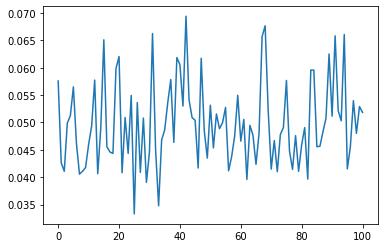

In [78]:
plt.plot(losses[1000:])

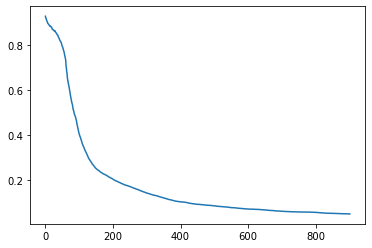

In [80]:
N = 100
smooth_losses = np.convolve(losses, np.ones(N)/N, mode='valid')
plt.plot(smooth_losses[100:])

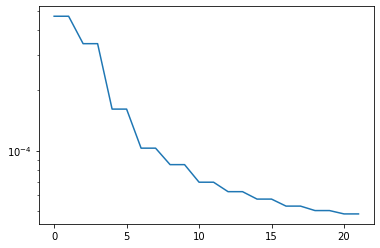

In [82]:
plt.semilogy(l1_distances)

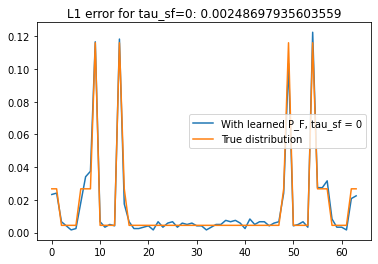